# 决策树
- 优点：计算复杂度不高，输出结果易于理解，对中间值的确实不敏感，可以处理不相关特征数据。
- 缺点：可能会产生过度拟合匹配问题。

## 信息增益

### 熵

定义为信息的期望值。

$x_{i}$的信息定义为：

$$l(x_{i})= -log_{2}p(x_{i})$$

其中$p(x_{i})$ 是概率。

为了计算熵，我们需要计算所有类别所有可能值所包含的信息期望值：

$$H = - \sum_{i=1}^{n}log_{2}p(x_{i})$$

In [5]:
# 计算给定数据集的熵

from math import log2

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    # 计算各个分类的个数
    for featVec in dataSet:
        currentLabel = featVec[-1]
        labelCounts[currentLabel] = labelCounts.get(currentLabel,0) + 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log2(prob)
    return shannonEnt

In [6]:
# 测试
def createDataSet():
    dataSet = [[1, 1, 'yes'],
              [1, 1, 'yes'],
              [1, 0, 'no'],
              [0, 1, 'no'],
              [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels
dataSet, labels = createDataSet()
print(dataSet)
print(labels)
print(calcShannonEnt(dataSet))
dataSet[0][-1] = 'maybe'
print(dataSet)
print(calcShannonEnt(dataSet))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
['no surfacing', 'flippers']
0.9709505944546686
[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
1.3709505944546687


In [19]:
# 划分数据集
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [15]:
def chooseBestFeatureToSplit(dataSet):
    numFeature = len(dataSet[0]) - 1 # 最后一个是类别不是feature
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain , bestFeature = 0.0, -1
    for i in range(numFeature): #对feature进行迭代
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList) #获取特定feature可能的取值
        newEntropy = 0.0
        #按照某个特定的feature进行划分后可以得到多组数据
        #然后计算每组数据的信息熵，再通过概率进行求和
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        #计算信息增益
        infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature


In [16]:
import operator
def majorityCnt(classList):
    '''在叶子节点计算主要类别'''
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote, 0) + 1
    sortedClassCount = sorted(classCount.items(),
                              key=operator.itemgetter(1),reverse = True)
    return sortedClassCount[0][0]

In [46]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1: #只有一个特征，即到达叶子
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = { bestFeatLabel:{} }
    del(labels[bestFeat])
    featValues = [ example[bestFeat] for example in dataSet ]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        # splitDataSet是一个函数，splitDataSet(dataSet, bestFeat, value)
        myTree[bestFeatLabel][value] = createTree(splitDataSet \
                                                  (dataSet, bestFeat, value),
                                                 subLabels)
    return myTree

In [47]:
myDat, labels = createDataSet()
tree = createTree(myDat, labels)
print(tree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## 使用Matplotlib绘制树形图

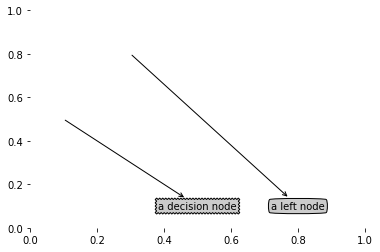

In [54]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, 
                            xycoords='axes fraction',
                           xytext=centerPt, textcoords="axes fraction",
                           va='center', ha='center', bbox=nodeType, 
                            arrowprops=arrow_args)
    
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False) #全局变量
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a left node',(0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

createPlot()

In [119]:
def getNumLeafs(myTrees):
    numLeafs = 0
    firstStr = list(myTrees.keys())[0]
    secondDict = myTrees[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs += 1
    return numLeafs

def getNumDepth(myTrees):
    print(myTrees)
    maxDepth = 0
    firstStr = list(myTrees.keys())[0]
    secondDict = myTrees[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getNumDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [123]:
# 测试：
def retrieveTree(i):
    listOfTrees = [
        {'no surfacing' : { 0: 'no', 1: {'flippers': \
                                        {0: 'no', 1: 'yes'}} }},
        {'no surfacing': {0: 'no', 1: {'flippers': \
            {0: {'head': {0 : 'no', 1: 'yes'}}, 1: 'no'}}}}
    ]
    return listOfTrees[i]
print(retrieveTree(0))
myTree = retrieveTree(0)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [124]:
getNumLeafs(myTree)

3

In [125]:
getNumDepth(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
{'flippers': {0: 'no', 1: 'yes'}}


2

In [150]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getNumLeafs(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,\
                              plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff),
                    cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff, plotTree.yOff = -0.5/plotTree.totalW, 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


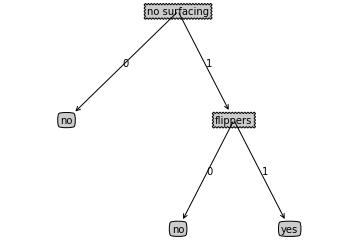

In [151]:
print(myTree)
createPlot(myTree)

In [152]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [155]:
print(myTree)
labels = ['no surfacing', 'flippers']
print(labels)
print(classify(myTree, labels, [1, 0]))


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
['no surfacing', 'flippers']
no


In [156]:
def storeTree(inputTree, fileName):
    import pickle
    with open(fileName, 'w') as f:
        pickle.dump(inputTree, f)

def grabTree(fileName):
    import pickle
    with open(fileName, 'w') as f:
        tree = pickle.load(f)
    return tree

# 预测隐形眼睛类型

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'young': 'hard', 'pre': 'no lenses', 'presbyopic': 'no lenses'}}, 'myope': 'hard'}}, 'no': {'age': {'young': 'soft', 'pre': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}}}}}}}


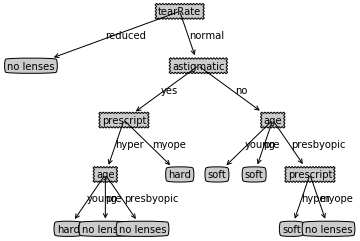

In [157]:
with open('lenses.txt') as f:
    lenses = [inst.strip().split('\t') for inst in f.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
print(lensesTree)
createPlot(lensesTree)